In [1]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-m9b48zjt/keras-ocr_44c9aabbd304478abe123a98715b8783
  Running command git clone --filter=blob:none --quiet https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-m9b48zjt/keras-ocr_44c9aabbd304478abe123a98715b8783
  Resolved https://github.com/faustomorales/keras-ocr.git to commit e8d34a46f07d50158e1d86d6c617e99bfe99e2f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00
  Created wheel for keras-ocr: filename=keras_ocr-0.0.0-py3-none-any.whl size=42309 sha256=58f8de206f8c98fe2cba2027710331aace2fabad6f592b9373c

In [9]:
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [1]:
data_dir = '.'

In [2]:
import zipfile
import datetime
import string
import glob
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [3]:
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for ./fonts.zip


Filtering fonts.: 100%|██████████| 2746/2746 [02:03<00:00, 22.25it/s]


Looking for ./backgrounds.zip


The first generated text is: Bed has South Pacific which
The first generated validation image (below) contains: Degr
ee some How
ever astron
omy flouris
hed in


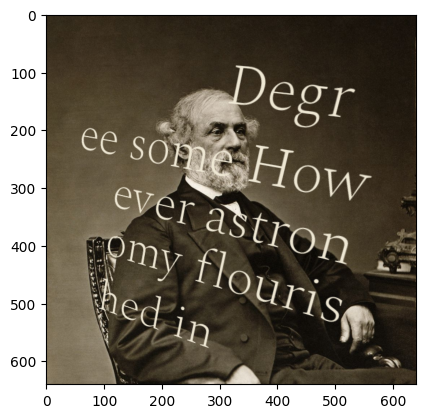

In [4]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [6]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan',
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [8]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit_generator(
    generator=detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=1,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size)
)

<ipython-input-8-fc1a8a5ff2f6>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  detector.model.fit_generator(


827/827 [==============================] - ETA: 0s - loss: 0.0063

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


827/827 [==============================] - 365s 441ms/step - loss: 0.0063 - val_loss: 0.0144


This image contains: O


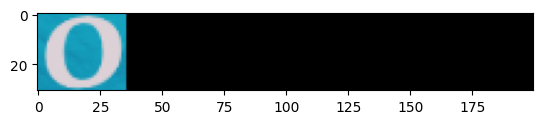

In [9]:
max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [17]:
recognition_train_generator

<frame at 0x787441d167c0, file '/usr/local/lib/python3.10/dist-packages/keras_ocr/recognition.py', line 471, code get_batch_generator>

In [ ]:
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=True
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    epochs=1,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
      tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
      tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
      tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0
)

In [ ]:
pipeline = keras_ocr.pipelines.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions])
plt.imshow(drawn)

In [ ]:
pipeline = keras_ocr.pipelines.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions])
plt.imshow(drawn)